# Goal of this notebook
Compute similarity(row_A, row_B) as `mean([cluster(row_A, view, model) == cluster(row_B, view, model) for each model in an ensemble` and for a view indicated via a variable of interest `context`. Use hierarchical clustering of all pairs (row_A, row_B) and map those clusters back to synthetic data. Note that this could be done with real data, too.


In [1]:
import edn_format
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sppl.compilers.spe_to_dict as spe_to_dict

from multiprocessing import Pool
from scipy.cluster.hierarchy import dendrogram, linkage
from sppl.transforms import Identity as I

In [2]:
# Load ensemble.
with open("../data/sppl/merged.json", "r") as f:
    ensemble = spe_to_dict.spe_from_dict(json.load(f))
# Record the number of models in the ensemble.
n_models = len(ensemble.children)

In [3]:
# Load probability of dependence. We'll use this to tune number
with open("../data/dep-prob.json", "r") as f:
    dep_prob = json.load(f)

In [4]:
# Load ASTs to look up the context of a variable.
def get_ast(i):
    """Reads i-th AST from disk."""
    with open(f"../data/ast/sample.{i}.edn", "r") as f:
        ast = edn_format.loads(f.read())
    return ast
asts = [get_ast(i) for i in range(n_models)]

In [5]:
def predictors(m, context):
    """Find the top m dependent columns for a context variable"""
    return [k for k,v in sorted(dep_prob[context].items(), key=lambda item: item[1])][0:m]

In [6]:
n = 500
context = "vaccination_status"
covariates = predictors(5, context)

In [7]:
# Generate a bunch of synthetic data rows
rows = ensemble.sample_subset([I(c) for c in covariates] + [I(context)], n)
# Record all pairs of rows.
pairs = list(itertools.combinations(range(n) ,2))

In [8]:
def get_view(model_index, context):
    """Get the view-ID for the `context` variable"""
    for vid, v in enumerate(asts[model_index][edn_format.Keyword("multimixture/views")]):
        if context in dict(
            v[edn_format.Keyword("view/clusters")][0][
                edn_format.Keyword("cluster/column->distribution")]        ).keys():
            return vid
        
def get_cluster_samples(model_index, context):
    """Sample a cluster id for a given model_index
    and context variable (indicating the view)"""
    vid = get_view(model_index, context)
    samples = []
    for row in rows:
        s = ensemble.children[model_index].constrain(row).sample_subset([I(f"view_{vid}_cluster")], 1)[0][
            I(f"view_{vid}_cluster")]
        samples.append(s)
    return samples

def get_agreement(model_index):
    """"For each pair of rows, check if the same cluster ID was sampled."""
    samples = get_cluster_samples(model_index, context)
    # return aggrement
    return [
        samples[i] == samples[j]
        for i,j in pairs
    ]

def get_similarity():
    """Compute similarity for all pairs of columns."""
    rows = ensemble.sample_subset([I(c) for c in covariates], n)
    pairs = list(itertools.combinations(range(len(rows)), 2))
    with Pool() as P:
        agreement_matrix = list(P.map(get_agreement, range(n_models)))
    return np.mean(np.asarray(agreement_matrix), axis=1)

In [9]:
# Compute aggreement, 
agreement = get_similarity()

[]

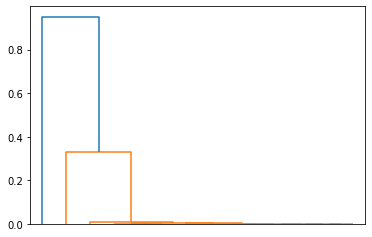

In [10]:
linkage_data = linkage([(s,) for s in agreement], method='centroid', metric='euclidean')
dendrogram(linkage_data)
ax = plt.gca()
ax.set_xticks([])

In [11]:
def extract_clusters(linkage_matrix, level_from_top):
    """Extract clustering for a given hieararchy level"""
    level = linkage_data.shape[0] - level_from_top
    # Initial clusters
    clusters = {i: [i] for i in range(linkage_matrix.shape[0] + 1)}

    # Go through the first "level" merges
    for i in range(level):
        merged_clusters = clusters.pop(linkage_matrix[i, 0])
        merged_clusters.extend(clusters.pop(linkage_matrix[i, 1]))
        clusters[linkage_matrix.shape[0] + 1 + i] = merged_clusters

    return clusters

In [12]:
clusters = extract_clusters(linkage_data, 2)

In [13]:
def get_rowids(i):
    cluster_id = list(clusters.keys())[i]
    rowids = []
    for pid in clusters[cluster_id]:
        rowids.extend(pairs[pid])
    return list(set(rowids))

In [14]:
df = pd.DataFrame(rows)
df = df.rename(columns={c:c.__str__() for c in rows[0].keys()})

In [15]:
def format(name, v):
    print(f"   {name}: {np.round(v, decimals=2)}")

def show_typical_vals(i):
    """Show typical vals for consensus cluster."""
    for c in df.columns:
        print(c)
        if df.dtypes[c]=="object":
            print(f"    Mode: {df.loc[get_rowids(i),c].mode()[0]}")
        else:
            format("Median", df.loc[get_rowids(i),c].median())
            format("Standard deviation", df.loc[get_rowids(i),c].std())

In [16]:
show_typical_vals(0)

vaccination_status
    Mode: (b) fully vaccinated but have not received a booster shot
US_citizen
    Mode: yes
divorced_last_year
    Mode: no
waiting_for_voting
    Mode: (a) Not at all
problem_voting
    Mode: no
where_was_ballot_returned
    Mode: Drop box used only for ballots, not located at an election office or polling place


In [17]:
show_typical_vals(1)

vaccination_status
    Mode: (a) fully vaccinated and have received at least one booster shot
US_citizen
    Mode: no
divorced_last_year
    Mode: no
waiting_for_voting
    Mode: (a) Not at all
problem_voting
    Mode: no
where_was_ballot_returned
    Mode: Drop box used only for ballots, not located at an election office or polling place


In [18]:
show_typical_vals(2)

vaccination_status
    Mode: (d) not vaccinated at all
US_citizen
    Mode: yes
divorced_last_year
    Mode: no
waiting_for_voting
    Mode: (a) Not at all
problem_voting
    Mode: no
where_was_ballot_returned
    Mode: Picked up by the postal worker who delivers mail to my home
